In [15]:
import tensorflow as tf
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential,Model,initializers,layers,Input
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [3]:
dir=r'D:\dataset\butterfly\train'
train_ds=tf.keras.preprocessing.image_dataset_from_directory(
dir,
labels="inferred",
label_mode="int",
class_names=None,
color_mode="rgb",
batch_size=4,
image_size=(299, 299),
shuffle=True,
seed=10,
validation_split=0.1,
subset='training',
interpolation="gaussian",
follow_links=False,
crop_to_aspect_ratio=False,)


validation_ds=tf.keras.preprocessing.image_dataset_from_directory(
dir,
labels="inferred",
label_mode="int",
class_names=None,
color_mode="rgb",
batch_size=4,
image_size=(299, 299),
shuffle=True,
seed=10,
validation_split=0.1,
subset='validation',
interpolation="gaussian",
follow_links=False,
crop_to_aspect_ratio=False,)

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255.)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

Found 1257 files belonging to 10 classes.
Using 1132 files for training.
Found 1257 files belonging to 10 classes.
Using 125 files for validation.


In [4]:
def Stem(x):
    x=layers.Conv2D(filters=32,kernel_size=(3,3),strides=(2,2))(x)
    x=layers.BatchNormalization()(x)
    x=layers.ReLU()(x)
    x=layers.Conv2D(filters=32,kernel_size=(3,3),strides=(1,1))(x)
    x=layers.BatchNormalization()(x)
    x=layers.ReLU()(x)
    x=layers.Conv2D(filters=64,kernel_size=(3,3),strides=(1,1),padding='same')(x)
    x=layers.BatchNormalization()(x)
    x=layers.ReLU()(x)
    x1=layers.MaxPooling2D(pool_size=(3,3),strides=(2,2))(x)
    x2=layers.Conv2D(filters=96,kernel_size=(3,3),strides=(2,2))(x)
    x2=layers.BatchNormalization()(x2)
    x2=layers.ReLU()(x2)
    x3=tf.keras.layers.Concatenate()([x1, x2])

    x4=layers.Conv2D(filters=64,kernel_size=(1,1),strides=(1,1))(x3)
    x4=layers.BatchNormalization()(x4)
    x4=layers.ReLU()(x4)
    x4=layers.Conv2D(filters=96,kernel_size=(3,3),strides=(1,1))(x4)
    x4=layers.BatchNormalization()(x4)
    x4=layers.ReLU()(x4)

    x5=layers.Conv2D(filters=64,kernel_size=(1,1),strides=(1,1))(x3)
    x5=layers.BatchNormalization()(x5)
    x5=layers.ReLU()(x5)
    x5=layers.Conv2D(filters=64,kernel_size=(7,1),strides=(1,1),padding='same')(x5)
    x5=layers.BatchNormalization()(x5)
    x5=layers.ReLU()(x5)
    x5=layers.Conv2D(filters=64,kernel_size=(1,7),strides=(1,1),padding='same')(x5)
    x5=layers.BatchNormalization()(x5)
    x5=layers.ReLU()(x5)
    x5=layers.Conv2D(filters=96,kernel_size=(3,3),strides=(1,1))(x5)
    x5=layers.BatchNormalization()(x5)
    x5=layers.ReLU()(x5)
    x6=tf.keras.layers.Concatenate()([x4, x5])

    x7=layers.MaxPooling2D(pool_size=(3,3),strides=(2,2))(x6)
    x8=layers.Conv2D(filters=192,kernel_size=(3,3),strides=(2,2))(x6)
    x8=layers.BatchNormalization()(x8)
    x8=layers.ReLU()(x8)
    x9=tf.keras.layers.Concatenate()([x7, x8])

    return x9


def Inception_ResNet_Block_A(x):
    x=layers.BatchNormalization()(x)
    x=layers.ReLU()(x)

    x1=layers.Conv2D(filters=32,kernel_size=(1,1),strides=(1,1),padding='same')(x)
    x1=layers.BatchNormalization()(x1)
    x1=layers.ReLU()(x1)

    x2=layers.Conv2D(filters=32,kernel_size=(1,1),strides=(1,1),padding='same')(x)
    x2=layers.BatchNormalization()(x2)
    x2=layers.ReLU()(x2)
    x2=layers.Conv2D(filters=32,kernel_size=(3,3),strides=(1,1),padding='same')(x2)
    x2=layers.BatchNormalization()(x2)
    x2=layers.ReLU()(x2)

    x3=layers.Conv2D(filters=32,kernel_size=(1,1),strides=(1,1),activation='relu',padding='same')(x)
    x3=layers.Conv2D(filters=48,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(x3)
    x3=layers.Conv2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(x3)

    x4=tf.keras.layers.Concatenate()([x,x1,x2,x3])
    x4=layers.Conv2D(filters=384,kernel_size=(1,1),strides=(1,1),padding='same')(x4)
    x4=layers.BatchNormalization()(x4)
    x4=layers.ReLU()(x4)
    x5=tf.keras.layers.Add()([x,x4])

    x5=layers.ReLU()(x5)
    return x5



def Inception_ResNet_Block_B(x):
    x=layers.BatchNormalization()(x)
    x=layers.ReLU()(x)    

    x1=layers.Conv2D(filters=192,kernel_size=(1,1),strides=(1,1),padding='same')(x)
    x1=layers.BatchNormalization()(x1)
    x1=layers.ReLU()(x1)

    x2=layers.Conv2D(filters=128,kernel_size=(1,1),strides=(1,1),padding='same')(x)
    x2=layers.BatchNormalization()(x2)
    x2=layers.ReLU()(x2)
    x2=layers.Conv2D(filters=160,kernel_size=(1,7),strides=(1,1),padding='same')(x2)
    x2=layers.BatchNormalization()(x2)
    x2=layers.ReLU()(x2)
    x2=layers.Conv2D(filters=192,kernel_size=(7,1),strides=(1,1),padding='same')(x2)
    x2=layers.BatchNormalization()(x2)
    x2=layers.ReLU()(x2)
    
    x3=tf.keras.layers.Concatenate()([x1,x2])

    x3=layers.Conv2D(filters=1152,kernel_size=(1,1),strides=(1,1),padding='same')(x3)
    x3=layers.BatchNormalization()(x3)
    x3=layers.ReLU()(x3)
    
    x4=tf.keras.layers.Add()([x,x3])

    x4=layers.ReLU()(x4)

    return x4


def Inception_ResNet_Block_C(x):
    x=layers.BatchNormalization()(x)
    x=layers.ReLU()(x)

    x1=layers.Conv2D(filters=192,kernel_size=(1,1),strides=(1,1),padding='same')(x)
    x1=layers.BatchNormalization()(x1)
    x1=layers.ReLU()(x1)

    x2=layers.Conv2D(filters=192,kernel_size=(1,1),strides=(1,1),padding='same')(x)
    x2=layers.BatchNormalization()(x2)
    x2=layers.ReLU()(x2)
    x2=layers.Conv2D(filters=224,kernel_size=(1,3),strides=(1,1),padding='same')(x2)
    x2=layers.BatchNormalization()(x2)
    x2=layers.ReLU()(x2)
    x2=layers.Conv2D(filters=256,kernel_size=(3,1),strides=(1,1),padding='same')(x2)
    x2=layers.BatchNormalization()(x2)
    x2=layers.ReLU()(x2)
    
    x3=tf.keras.layers.Concatenate()([x1,x2])

    x3=layers.Conv2D(filters=2048,kernel_size=(1,1),strides=(1,1),padding='same')(x3)
    x3=layers.BatchNormalization()(x3)
    x3=layers.ReLU()(x3)
    
    x4=tf.keras.layers.Add()([x,x3])

    x4=layers.ReLU()(x4)

    return x4


def Reduction_Block_A(x):
    x4=layers.MaxPooling2D(pool_size=(3,3),strides=(2,2))(x)

    x1=layers.Conv2D(filters=384,kernel_size=(3,3),strides=(2,2))(x)
    x1=layers.BatchNormalization()(x1)
    x1=layers.ReLU()(x1)

    x2=layers.Conv2D(filters=256,kernel_size=(1,1),strides=(1,1),padding='same')(x)
    x2=layers.BatchNormalization()(x2)
    x2=layers.ReLU()(x2)

    x2=layers.Conv2D(filters=256,kernel_size=(3,3),strides=(1,1),padding='same')(x2)
    x2=layers.BatchNormalization()(x2)
    x2=layers.ReLU()(x2)
    x2=layers.Conv2D(filters=384,kernel_size=(3,3),strides=(2,2),activation='relu')(x2)
    x2=layers.BatchNormalization()(x2)
    x2=layers.ReLU()(x2)

    x3=tf.keras.layers.Concatenate()([x4,x1,x2])
    
    return x3 



def Reduction_Block_B(x):
    x1=layers.MaxPooling2D(pool_size=(3,3),strides=(2,2))(x)

    x2=layers.Conv2D(filters=256,kernel_size=(1,1),strides=(1,1),padding='same')(x)
    x2=layers.BatchNormalization()(x2)
    x2=layers.ReLU()(x2)
    x2=layers.Conv2D(filters=288,kernel_size=(3,3),strides=(2,2))(x2)
    x2=layers.BatchNormalization()(x2)
    x2=layers.ReLU()(x2)
    

    x3=layers.Conv2D(filters=256,kernel_size=(1,1),strides=(1,1),padding='same')(x)
    x3=layers.BatchNormalization()(x3)
    x3=layers.ReLU()(x3)
    x3=layers.Conv2D(filters=288,kernel_size=(3,3),strides=(2,2))(x3)
    x3=layers.BatchNormalization()(x3)
    x3=layers.ReLU()(x3)

    x4=layers.Conv2D(filters=256,kernel_size=(1,1),strides=(1,1),padding='same')(x)
    x4=layers.BatchNormalization()(x4)
    x4=layers.ReLU()(x4)
    x4=layers.Conv2D(filters=288,kernel_size=(3,3),strides=(1,1),padding='same')(x4)
    x4=layers.BatchNormalization()(x4)
    x4=layers.ReLU()(x4)
    x4=layers.Conv2D(filters=320,kernel_size=(3,3),strides=(2,2))(x4)
    x4=layers.BatchNormalization()(x4)
    x4=layers.ReLU()(x4)

    x5=tf.keras.layers.Concatenate()([x1,x2,x3,x4])
    
    return x5 

In [5]:

input=layers.Input(shape=(299,299,3))
x=Stem(input)
    
x=Inception_ResNet_Block_A(x)
x=Inception_ResNet_Block_A(x)
x=Inception_ResNet_Block_A(x)
x=Inception_ResNet_Block_A(x)
x=Inception_ResNet_Block_A(x)
    
x6=Reduction_Block_A(x)
    
x6=Inception_ResNet_Block_B(x6)#1
x6=Inception_ResNet_Block_B(x6)#2
x6=Inception_ResNet_Block_B(x6)#3
x6=Inception_ResNet_Block_B(x6)#4
x6=Inception_ResNet_Block_B(x6)#5
x6=Inception_ResNet_Block_B(x6)#6
x6=Inception_ResNet_Block_B(x6)#7
x6=Inception_ResNet_Block_B(x6)#8
x6=Inception_ResNet_Block_B(x6)#9
x6=Inception_ResNet_Block_B(x6)#10
    
x6=Reduction_Block_B(x6)
    
x6=Inception_ResNet_Block_C(x6)#1
x6=Inception_ResNet_Block_C(x6)#2
x6=Inception_ResNet_Block_C(x6)#3
x6=Inception_ResNet_Block_C(x6)#4
x6=Inception_ResNet_Block_C(x6)#5
    
x6=layers.GlobalAveragePooling2D()(x6)
x6=layers.Dropout(0.8)(x6)
x6=layers.Dense(units=10,activation='softmax')(x6)
    
model = tf.keras.models.Model(input,x6)

In [6]:
model.build(input_shape=(299, 299, 3))

In [27]:
len(model.layers)

479

In [8]:
model_checkpoint_best_path=r'D:\GitHub_repo\CNN-Model-Study\save_weights\InceptionResnetv2/'
model_checkpoint_best=ModelCheckpoint(filepath=model_checkpoint_best_path,monitor='val_acc',save_best_only=True,save_weights_only=True,save_freq='epoch')
early_stopping=EarlyStopping(monitor='val_acc',patience=30,min_delta=1e-4)

In [10]:
lr_rate=tf.keras.optimizers.schedules.ExponentialDecay(1e-3, 10000, 0.97, staircase=False, name=None)
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy' ,metrics=['acc'])

In [11]:
with tf.device("/device:GPU:0"):
    history=model.fit(train_ds,validation_data=validation_ds,epochs=50,batch_size=4,verbose=1)

Epoch 1/50
283/283 [==============================] - 93s 257ms/step - loss: 3.1826 - acc: 0.1219 - val_loss: 14.3972 - val_acc: 0.0880
Epoch 2/50
283/283 [==============================] - 70s 247ms/step - loss: 2.6314 - acc: 0.1749 - val_loss: 2.1175 - val_acc: 0.2320
Epoch 3/50
283/283 [==============================] - 70s 248ms/step - loss: 2.5411 - acc: 0.1882 - val_loss: 19.2433 - val_acc: 0.1600
Epoch 4/50
283/283 [==============================] - 68s 240ms/step - loss: 2.4393 - acc: 0.2208 - val_loss: 11.7548 - val_acc: 0.1920
Epoch 5/50
283/283 [==============================] - 69s 243ms/step - loss: 2.3800 - acc: 0.2491 - val_loss: 2.9881 - val_acc: 0.3440
Epoch 6/50
283/283 [==============================] - 66s 233ms/step - loss: 2.2135 - acc: 0.2933 - val_loss: 1.9296 - val_acc: 0.3280
Epoch 7/50
283/283 [==============================] - 65s 228ms/step - loss: 2.1591 - acc: 0.3277 - val_loss: 6.0524 - val_acc: 0.1920
Epoch 8/50
283/283 [==============================] 

In [ ]:
model.load_weights(model_checkpoint_best_path)
test_loss,test_acc=model.evaluate(validation_ds,verbose=1)

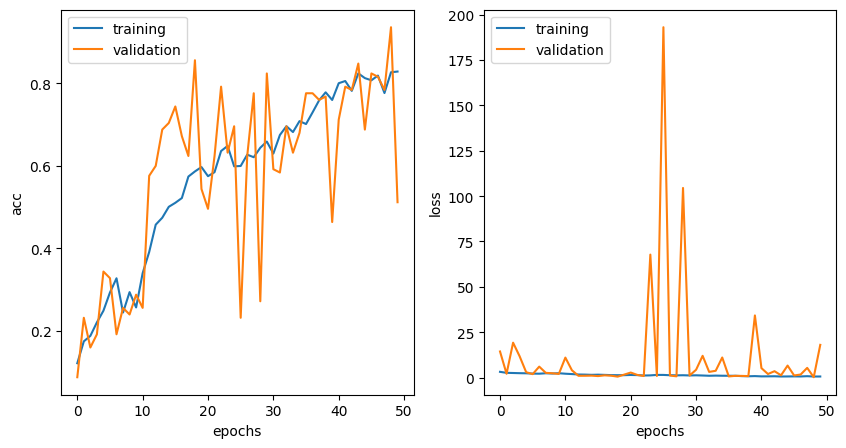

In [16]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('acc')
plt.xlabel('epochs')
plt.legend(['training','validation'],loc='upper left')

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['training','validation'],loc='upper left')

plt.show()